In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLXPNR9/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLXPNR9/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLXPNR9/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np 
train_data, test_data = imdb['train'], imdb['test']

In [5]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

In [6]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [7]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 10
model.fit(padded,
          training_labels_final,
          epochs=num_epochs,
          validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 7s 7ms/step - loss: 0.5592 - accuracy: 0.7412 - val_loss: 0.3988 - val_accuracy: 0.8352
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3368 - accuracy: 0.8608 - val_loss: 0.3330 - val_accuracy: 0.8579
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2738 - accuracy: 0.8885 - val_loss: 0.3292 - val_accuracy: 0.8583
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2376 - accuracy: 0.9057 - val_loss: 0.3398 - val_accuracy: 0.8556
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2119 - accuracy: 0.9199 - val_loss: 0.3558 - val_accuracy: 0.8512
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1911 - accuracy: 0.9293 - val_loss: 0.3806 - val_accuracy: 0.8452
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1735 - accuracy: 0.9388 - val_loss: 0.4104 - val_accuracy: 0.8378
Epoch 

In [12]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(10000, 16)


In [13]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

In [14]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf8')
out_m = io.open('meta.tsv', 'w', encoding='utf8')

# Initialize the loop. Start counting at '1' because '0' is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated at the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [15]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Truy cập : https://projector.tensorflow.org/

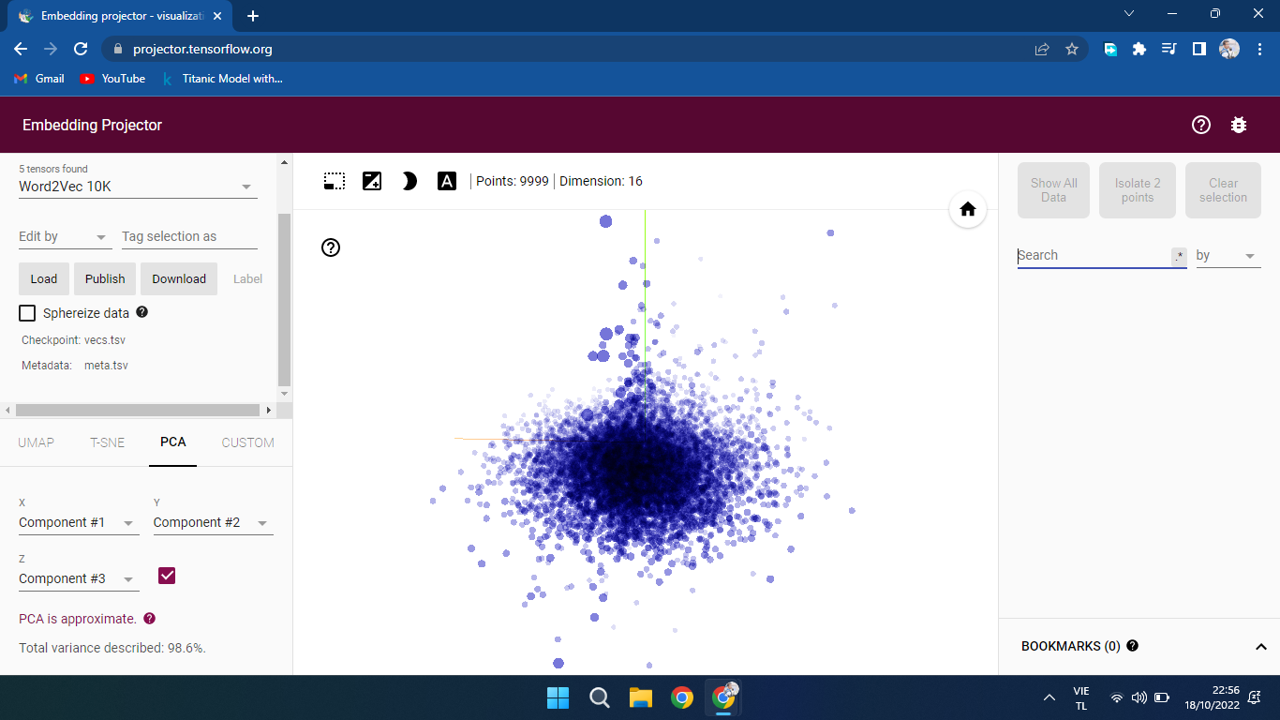